In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture

from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans

# Assignment 3 - Clustering

For this assignment you'll need to use some clustering knowledge to build a function that can generate handwritten numbers from a provided number. 

The modelling parts of this assignment are not very complex, the application of the clustering algorithms is very similar to the examples from class. This will require a little more manipulation of data, and building a little bit of structure around the models, that's where some of the challenge lies. 

## Requirements
<ul>
<li>Use clustering to take the X data (the features/pixels) of the MNIST dataset, and group it into clusters. 
    <ul>
    <li> Do not use the targets from the dataset at all. 
    <li> Use as many clusters as you think is appropriate.
    </ul>
<li>Assign labels to your clusters, so there is now a label for each cluster. You'll need to manually do a little mapping here by eye. 
<li><b>So, to this point. You take the images, ditch their labels, and do clustering to group them. You don't know which cluster is which digit. You have to then label them, or look at each one and say, "looks like 7s", then assign that group a label of 7. </b>
<li>Use GMM to build a function that can generate a new digit from the information in the cluster. 
<li>Write a function, writeNumber, that can take in an integer (you can assume it is between 1 and 20 digits, this is mostly for printing purposes, the modelling part isn't impacted by this at all) and print out that integer as a generated handwritten number. 
<li><b>When generating the handwritten numbers, each version of a digit should be different. I.e. If the number printed is 22222, there should not be 5 identical 2s, they should vary a bit like real writing. Each digit should be a new generation of data.</b>
</ul>

## Deliverables
Submit your .ipynb file to the Moodle dropbox. PLEASE make sure that the file runs BY ITSELF outside of importing libraries. It should not reference any other files, either data or code. 

Within your file, create a function called writeNumber, which takes a number as an input, and prints it out as a series of handwritten digits. The function should be callable like this, if I wanted to print the number 218201

~~~
writeNumber(218201)
~~~

This would produce something that looks, somewhat, like this:

![Writing Example](example.png "Writing Example" )

The exact appearance of the generated writing can vary, it likely won't be as well defined as this picture. As long as I can read it as a number, it is fine. 

Hint: the number of clusters may vary. 

## Grading
<ul>
<li> 70% - Code works. This is mostly a yes/no thing, if it doesn't work I'll try to see if it was a small or large issue in the code, but it largely works or it doesn't. 
<li> 20% - Numbers appearance. Is the writing OK? I'm not going to be overly picky, if they are reasonably legible, that is fine. 
<li> 10% - Code legibility. Is a quick read over of the code clear? Sections, comments, etc... 
</ul>

## Load Data
<b> Please do not change this (substantially), probably outside of choosing between the full data and a subset. Don't load the target. </b>

Note: testing will be much faster with a subset of records. 

In [2]:
#Load Data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
#mnist = mnist[0:15000]
X = mnist["data"]
print(X.shape)

(70000, 784)


### NORMALIZING DATA:

Normalizing the data means scaling the values of the data to a common range so that they can be compared on the same scale. In the given code, the line X = mnist.data / 255.0 normalizes the pixel values in the MNIST dataset by dividing each pixel value by 255.0, which is the maximum possible pixel value. This results in all the pixel values being scaled down to a range between 0 and 1.

This step is important because clustering algorithms can be sensitive to the scale of the data. Normalizing the data ensures that each feature (in this case, pixel) contributes equally to the clustering process, regardless of its original scale.

In [3]:
X = mnist.data / 255.0 # normalize the data

In [4]:
X= X.sample(30000)

In [5]:
X = mnist.data.astype('float64')

## Cluster 

We need to break the data into clusters first... 

### Applying K-mean clustering of data:

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(X)
kmeans.cluster_centers_.shape

In [6]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42).fit(X)

##### Create a KMeans object with 10 clusters
kmeans = KMeans(n_clusters=10)

##### Fit the KMeans model to the data
kmeans.fit(X)

##### Predict the cluster labels for each data point
labels = kmeans.predict(X)

### VISUALIZING THE RESULT:

###### WorkBook Example:

fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

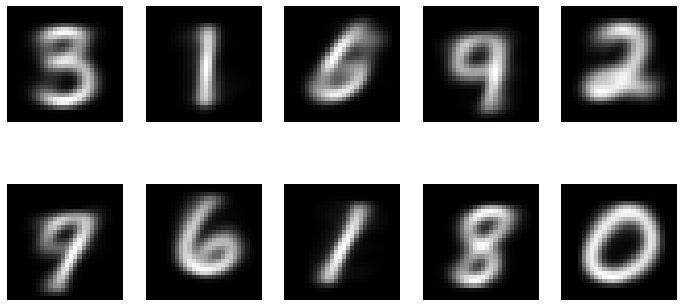

In [7]:
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(kmeans.cluster_centers_[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()


In [8]:


#cluster_labels = {0: 8, 1: 9, 2: 3, 3: 2, 4: 7, 5: 6, 6: 1, 7: 4, 8: 0, 9: 5}

cluster_ids = kmeans.predict(X)

image_labels = {3: 0, 1: 1, 5: 2, 9: 3, 2: 4, 4: 5, 6: 6, 7: 7, 8: 8, 0: 9}

cluster_labels = {cluster_id: image_labels[image_label] for cluster_id, image_label in enumerate([3,1,5,9,2,4,6,7,8,0])}

predicted_labels = [cluster_labels[cluster_id] for cluster_id in cluster_ids]


In [9]:
for i in range(10):
    cluster_data = X[cluster_ids == i]
    print(f"Cluster {i} data shape: {cluster_data.shape}")

Cluster 0 data shape: (8674, 784)
Cluster 1 data shape: (6658, 784)
Cluster 2 data shape: (6482, 784)
Cluster 3 data shape: (10446, 784)
Cluster 4 data shape: (5312, 784)
Cluster 5 data shape: (9974, 784)
Cluster 6 data shape: (4979, 784)
Cluster 7 data shape: (5322, 784)
Cluster 8 data shape: (6771, 784)
Cluster 9 data shape: (5382, 784)


In [10]:
from sklearn.mixture import GaussianMixture

# Convert cluster_ids to 1-dimensional array of integers
cluster_ids = cluster_ids.squeeze().astype(int)

gmms = []
for i in range(10):
    cluster_data = X[cluster_ids == i]
    gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=42)
    gmm.fit(cluster_data)
    gmms.append(gmm)

In [11]:
for i in range(10):
    cluster_data = X[cluster_ids == i]
    print(f"Cluster {i} data shape: {cluster_data.shape}")

Cluster 0 data shape: (8674, 784)
Cluster 1 data shape: (6658, 784)
Cluster 2 data shape: (6482, 784)
Cluster 3 data shape: (10446, 784)
Cluster 4 data shape: (5312, 784)
Cluster 5 data shape: (9974, 784)
Cluster 6 data shape: (4979, 784)
Cluster 7 data shape: (5322, 784)
Cluster 8 data shape: (6771, 784)
Cluster 9 data shape: (5382, 784)


In [12]:
def writeNumber(num):
    fig, axs = plt.subplots(1, len(num), figsize=(len(num)*2, 2))
    for i, digit in enumerate(num):
        cluster_id = image_labels[int(digit)]
        cluster_data = X[cluster_ids == cluster_id]
        if len(cluster_data) > 0:
            gmm = gmms[cluster_id]
            sample = gmm.sample()[0]
            image = sample.reshape((28, 28))  # modify the image shape to (28, 28)
            axs[i].imshow(image, cmap='gray')
        else:
            axs[i].imshow(np.zeros((28, 28)), cmap='gray') # display a black image for empty clusters
        axs[i].axis('off')
    plt.show()


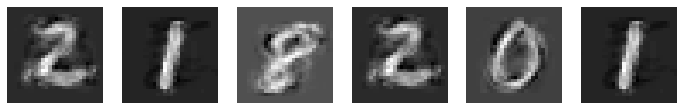

In [13]:
writeNumber('218201')

In [14]:
def writeNumber1(num1):
    fig, axs = plt.subplots(1, len(num1), figsize=(len(num1)*2, 2))
    for i, digit in enumerate(num1):
        cluster_id = image_labels[int(digit)]
        cluster_data = X[cluster_ids == cluster_id]
        if len(cluster_data) > 0:
            gmm = gmms[cluster_id]
            component_idx = np.random.randint(gmm.n_components) # randomly select a component index
            gmm.set_params(random_state=component_idx) # set the random state to the selected component index
            sample = gmm.sample()[0] # generate a random sample from the GMM
            image = sample.reshape((28, 28))  # modify the image shape to (28, 28)
            axs[i].imshow(image, cmap='gray')
        else:
            axs[i].imshow(np.zeros((28, 28)), cmap='gray') # display a black image for empty clusters
        axs[i].axis('off')
    plt.show()

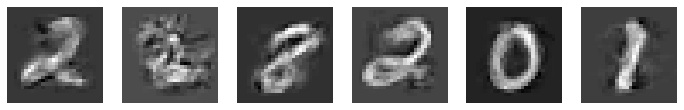

In [15]:
writeNumber1('218201')

In [ ]:
writeNumber1('573495')